# Description
In a [previous project](https://github.com/maxantcliff/football_poisson_2/blob/master/football_poisson_2.ipynb) I tried placing bets on the English Premier League based on my estimations of the probability of an outcome, derived through a rather crude poisson distribution. Here, I want to evaluate the accuracy/validity of using this distribution to estimate the probability of each outcome. 

# Preliminaries
Importing packages, defining poisson distribution, creating the average values for home and away goals from the previous season to be used in the poisson distirbution. For a much fuller explanation of these parts, see the [repository](https://github.com/maxantcliff/football_poisson_2/blob/master/football_poisson_2.ipynb) that this is evaluating.

In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
os.chdir('/Users/maxantcliff/Desktop/Python')

In [2]:
def poisson(actual, mean):
    return(mean**actual*math.exp(-mean))/math.factorial(actual)

In [3]:
def make_teamlist(data):
    teamlist=[]
    for i in range(len(data)):
        if data.HomeTeam[i] not in teamlist:
            teamlist.append(data.HomeTeam[i])
    teamlist.sort()
    return(teamlist)

In [22]:
def make_teaminfo(data):
    teamlist=make_teamlist(data)
    columns=['home_goals', 'away_goals', 'home_conceded', 'away_conceded',
                 'home_games', 'away_games','total_games', 'alpha_h','beta_h','alpha_a','beta_a']
    teaminfo = pd.DataFrame(index=teamlist, columns = columns)
    teaminfo[(columns)]=0
    for i in range(len(data)):
        teaminfo['home_games'][(data.HomeTeam[i])]+=1
        teaminfo['away_games'][(data.AwayTeam[i])]+=1
        teaminfo['home_goals'][(data.HomeTeam[i])]+=data.FTHG[i]
        teaminfo['away_goals'][(data.AwayTeam[i])]+=data.FTAG[i]
        teaminfo['home_conceded'][(data.HomeTeam[i])]+=data.FTAG[i]
        teaminfo['away_conceded'][(data.AwayTeam[i])]+=data.FTHG[i]
    teaminfo['alpha_h']=teaminfo['home_goals']/teaminfo['home_games']
    teaminfo['beta_h']=teaminfo['home_conceded']/teaminfo['home_games']
    teaminfo['alpha_a']=teaminfo['away_goals']/teaminfo['away_games']
    teaminfo['beta_a']=teaminfo['away_conceded']/teaminfo['away_games']
    teaminfo['total_games']=teaminfo['home_games']+teaminfo['away_games']
    return(teaminfo)

# Whole Season Level Evaluation

The below plots the proportion of matches with a given number of home goals scored against what the poission distribution of the same stat, using the average number of home goals from the *previous* season as $\lambda$.

In [23]:
def whole_season_plot(betting_year):
    data_year=betting_year-1
    data=pd.read_csv('data/EPL/%d.csv'%(data_year),usecols=['HomeTeam','AwayTeam','FTHG','FTAG'])
    season=pd.read_csv('data/EPL/%d.csv'%(betting_year),usecols=['HomeTeam','AwayTeam','FTHG','FTAG'])
    goals=8
    poiss= np.zeros([goals,2])
    for i in range(goals):
        poiss[i,0]=poisson(i, data.mean()['FTHG'])
        poiss[i,1]=poisson(i, data.mean()['FTAG'])
    poisson_pred=pd.DataFrame(data=poiss, columns=['Home','Away'])
    plt.hist(season[['FTHG','FTAG']].values, range(goals), density=True, label=['Home','Away']
             ,alpha=0.6, color=['Red','Blue'])
    plt.xticks([i-0.5 for i in range(1,goals+2)],[i for i in range(goals+2)])
    plt.ylim([0, 0.4])
    plt.ylabel("Proportion of Matches")
    plt.title("Goals per Match: Actual vs. Poisson Prediction (20{}/{} Season)".format(data_year,data_year+1))
    plt.xlabel("Goals per Match")
    plt.plot([i-0.66 for i in range(1,goals+1)],poisson_pred['Home'], label='Home', linestyle='-', marker='o',color='red')
    plt.plot([i-0.33 for i in range(1,goals+1)],poisson_pred['Away'],label='Away',linestyle='-', marker='o', color='blue')
    leg=plt.legend(loc='upper right', fontsize=9, ncol=2)
    leg.set_title("Poisson           Actual      ", prop = {'size':'10', 'weight':'bold'})
    plt.annotate("Notes: Poisson predictions are based on average home and away goals from the previous season", 
                 (0,-0.1), (0, -22), xycoords='axes fraction', textcoords='offset points', va='top')

Try it out for a couple of seasons:

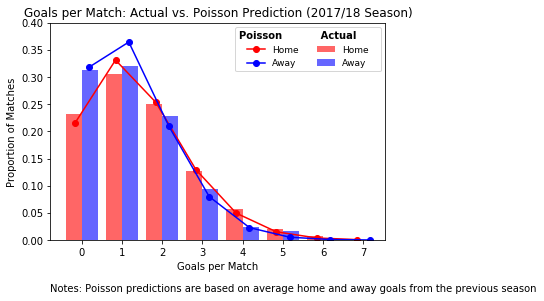

In [35]:
whole_season_plot(18)

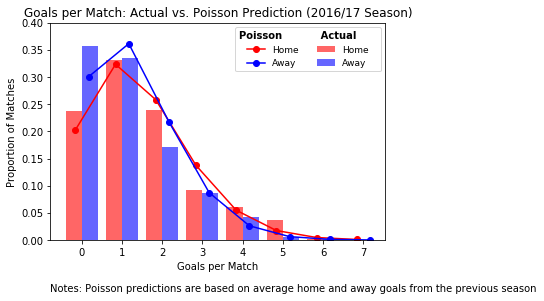

In [36]:
whole_season_plot(17)

So this method doesn't seem too bad, from eyeballing that graph. However, this is across a whole season: it could be that under-represented scores are cancelled out by over-represented scores so that when it comes to predicting individual matches, it's much worse. This brings us onto the next evaluation:

# Individual Teams

A similar method to above, but this time for individual teams. As it's currently written, it won't work for a newly promoted team.

In [25]:

def one_team_plot(year, team):
    betting_year=year
    team=team
    data_year=betting_year-1
    data=pd.read_csv('data/EPL/%d.csv'%(data_year),usecols=['HomeTeam','AwayTeam','FTHG','FTAG'])
    season=pd.read_csv('data/EPL/%d.csv'%(betting_year),usecols=['HomeTeam','AwayTeam','FTHG','FTAG'])
    teamlist=make_teamlist(data)
    teaminfo=make_teaminfo(data)
    goals=8
    home_actual=data[data['HomeTeam']==team][['FTHG']].apply(pd.value_counts,normalize=True)
    home_actual=home_actual.sort_index()
    away_actual=data[data['AwayTeam']==team][['FTAG']].apply(pd.value_counts,normalize=True)
    away_actual=away_actual.sort_index()
    actual=pd.DataFrame(data=home_actual ,index=(range(goals)))
    actual=pd.concat([actual,away_actual],axis=1)
    home_poiss= np.zeros([goals])
    for i in range(goals):
        home_poiss[i]=poisson(i,teaminfo.alpha_h[team])
    away_poiss=np.zeros([goals])
    for i in range(goals):
        away_poiss[i]=poisson(i,teaminfo.alpha_a[team])
    plt.bar(actual.index-0.7, actual.FTHG,width=0.4,color='#0a7bff',label='Home')
    plt.bar(actual.index-0.3, actual.FTAG,width=0.4,color='#ff7c89',label='Away')
    plt.ylim([0, 0.5])
    plt.xticks([i-1.5 for i in range(1,goals+2)],[i for i in range(goals+2)])
    plt.ylabel("Proportion of Matches")
    plt.title("{}'s Goals per Match: Actual vs. Poisson (20{}/{} Season)".format(team,data_year,data_year+1))
    plt.xlabel("Goals per Match")
    plt.plot([i-1.69 for i in range(1,goals+1)],home_poiss, label='Home', linestyle='-', marker='o',color='blue')
    plt.plot([i-1.33 for i in range(1,goals+1)],away_poiss,label='Away',linestyle='-', marker='o', color='red')
    leg=plt.legend(loc='upper right', fontsize=9, ncol=2)
    leg.set_title("  Poisson       Actual    ", prop = {'size':'10', 'weight':'bold'})
    plt.annotate("Notes: Poisson predictions are based on the team's average home and away goals from the previous season", 
                 (0,-0.1), (0, -22), xycoords='axes fraction', textcoords='offset points', va='top')

Try it on a couple of teams:

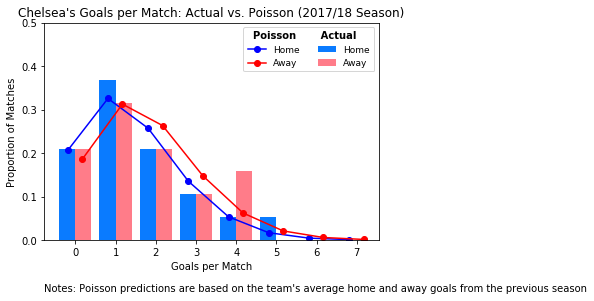

In [28]:
one_team_plot(18,'Chelsea')

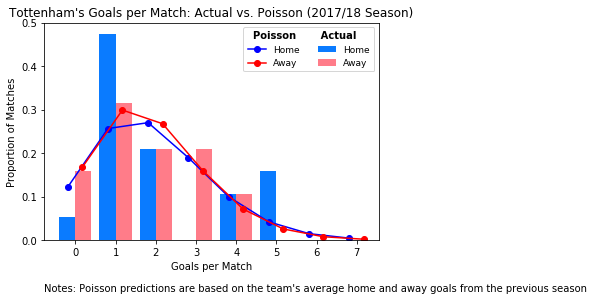

In [30]:
one_team_plot(18,'Tottenham')

Here we see it doesn't do all that well. Probably explains the awful predictive power of the method!

# Validity

For the Poisson distribution to even be valid (ignoring accuracy), the distribution of events needs to be constant (and proportional) so that if the Poisson of a whole match is accurate using $\lambda$, then you should also be able to just use $\lambda/2$ to estimate the number of goals per half. For this to hold, we should see the same number of goals in the first and second halves on average, so I test that out using the below:

In [33]:

def halves_difference(year):
    goals=8
    data_year=year
    data=pd.read_csv('data/EPL/%d.csv'%(data_year),usecols=['FTHG','FTAG','HTHG','HTAG'])
    for i in range(data_year-10,data_year):
        other=pd.read_csv('data/EPL/%d.csv'%(i),usecols=['FTHG','FTAG','HTHG','HTAG'])
        data=pd.concat([data,other])
    data['FHG']=data['HTHG']+data['HTAG']
    data['SHG']=data['FTHG']+data['FTAG']-data['FHG']
    data['delta']=data['FHG']-data['SHG']
    data['delta']=abs(data['delta'])
    plt.hist(data[['delta']].values, range(goals),density=True,alpha=0.6, color=['Blue'],rwidth=0.5)
    plt.xticks([i-0.5 for i in range(1,goals+2)],[i for i in range(goals+2)])
    plt.ylim([0, 0.4])
    plt.ylabel("Proportion of Matches")
    plt.title("First vs. Second Half Goals ({}-{})".format(2000+data_year-10,2000+data_year+1))
    plt.xlabel("Difference Between Goals Scored in First vs. Second Half")

Run it for the 10 seasons up until the most recent one:

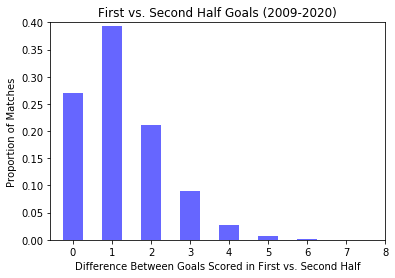

In [34]:
halves_difference(19)

Based on the above graph, whilst I haven't run any more rigorous stats calculation, there's no doubt that with 10 years of data the difference between goals scored in the first and second halves is statistically different from zero. So you could conclude that this whole process was pointless!

# Conclusion

Shockingly, it turns out that a Poisson distribution using the previous season's average goals is neither accurate nor valid.